In [ ]:
import sys
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import mne

import eegviz
from eegviz import EvData

from pprint import pprint

In [ ]:
def sleep_stage_converter(sample):
    new = np.zeros(len(sample))
    for si, s in enumerate(sample):
        if s == 0:
            new[si] = 5
        elif s == 4:
            new[si] = 4
        elif s == 1:
            new[si] = 3
        elif s == 2:
            new[si] = 2
        elif s == 3:
            new[si] = 1
    return new

def awake_converter(sample2):
    new = np.zeros(len(sample2))
    for si, s in enumerate(sample2):
        if s == 1:
            new[si] = 5
        elif s == 0:
            new[si] = 1
    return new


In [ ]:
#stages = np.load(stage_file)
vhdr = EvData(vhdr_file)

Loading /home/kiss/data/fmri_shared/dream_rem/TH180507/eeg/denoised/export2/TH180507_fmri_1_Filters.vhdr with mne.io.read_raw_brainvision
Extracting parameters from /home/kiss/data/fmri_shared/dream_rem/TH180507/eeg/denoised/export2/TH180507_fmri_1_Filters.vhdr...
Setting channel info structure...


/home/maeno/eeg/eegviz.py:164: RuntimeWarning: No coordinate information found for channels ['HGL', 'HGR', 'SO', 'IO', 'SM1', 'SM2', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(fname)


In [ ]:
# Get some data information

# Channels
channels = vhdr.channels
print(channels)

# Sampling frequency
sample_freq = vhdr.sampling_frequency
print(sample_freq)

# Available event names
event_names = vhdr.event_names
print(event_names)
if 'Scanner/Scan Start' in event_names:
    print("")
    print("This data includes 'Scanner/Scan Start' !!")
    print("")

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'PO3', 'PO4', 'HGL', 'HGR', 'SO', 'IO', 'SM1', 'SM2', 'PO7', 'PO8', 'POz', 'ECG']
250.0
['New Segment/', 'SyncStatus/Sync On', 'Pulse Artifact/R', 'Scanner/Scan Start', 'Comment/Sleeping', 'Comment/Awaking', 'Comment/left', 'Comment/right', 'Comment/up', 'Comment/down', 'TPULSE/TSTART', 'TPULSE/TPEAK', 'TPULSE/TEND']

This data includes 'Scanner/Scan Start' !!



sleep button: [89.02, 131.72, 530.7, 796.62, 1528.48, 2386.74, 3269.9]
awake button: [94.64, 492.56, 746.78, 1496.36, 2303.62, 3089.02, 3997.62]
right button: [105.28, 111.68]
left button: [102.92, 108.34]
0 7000
0 7000
0 7000
0 7000
0 7000
0 7000
0 7000
Saved file: TH180507_ses1_run1.csv
len: 1342


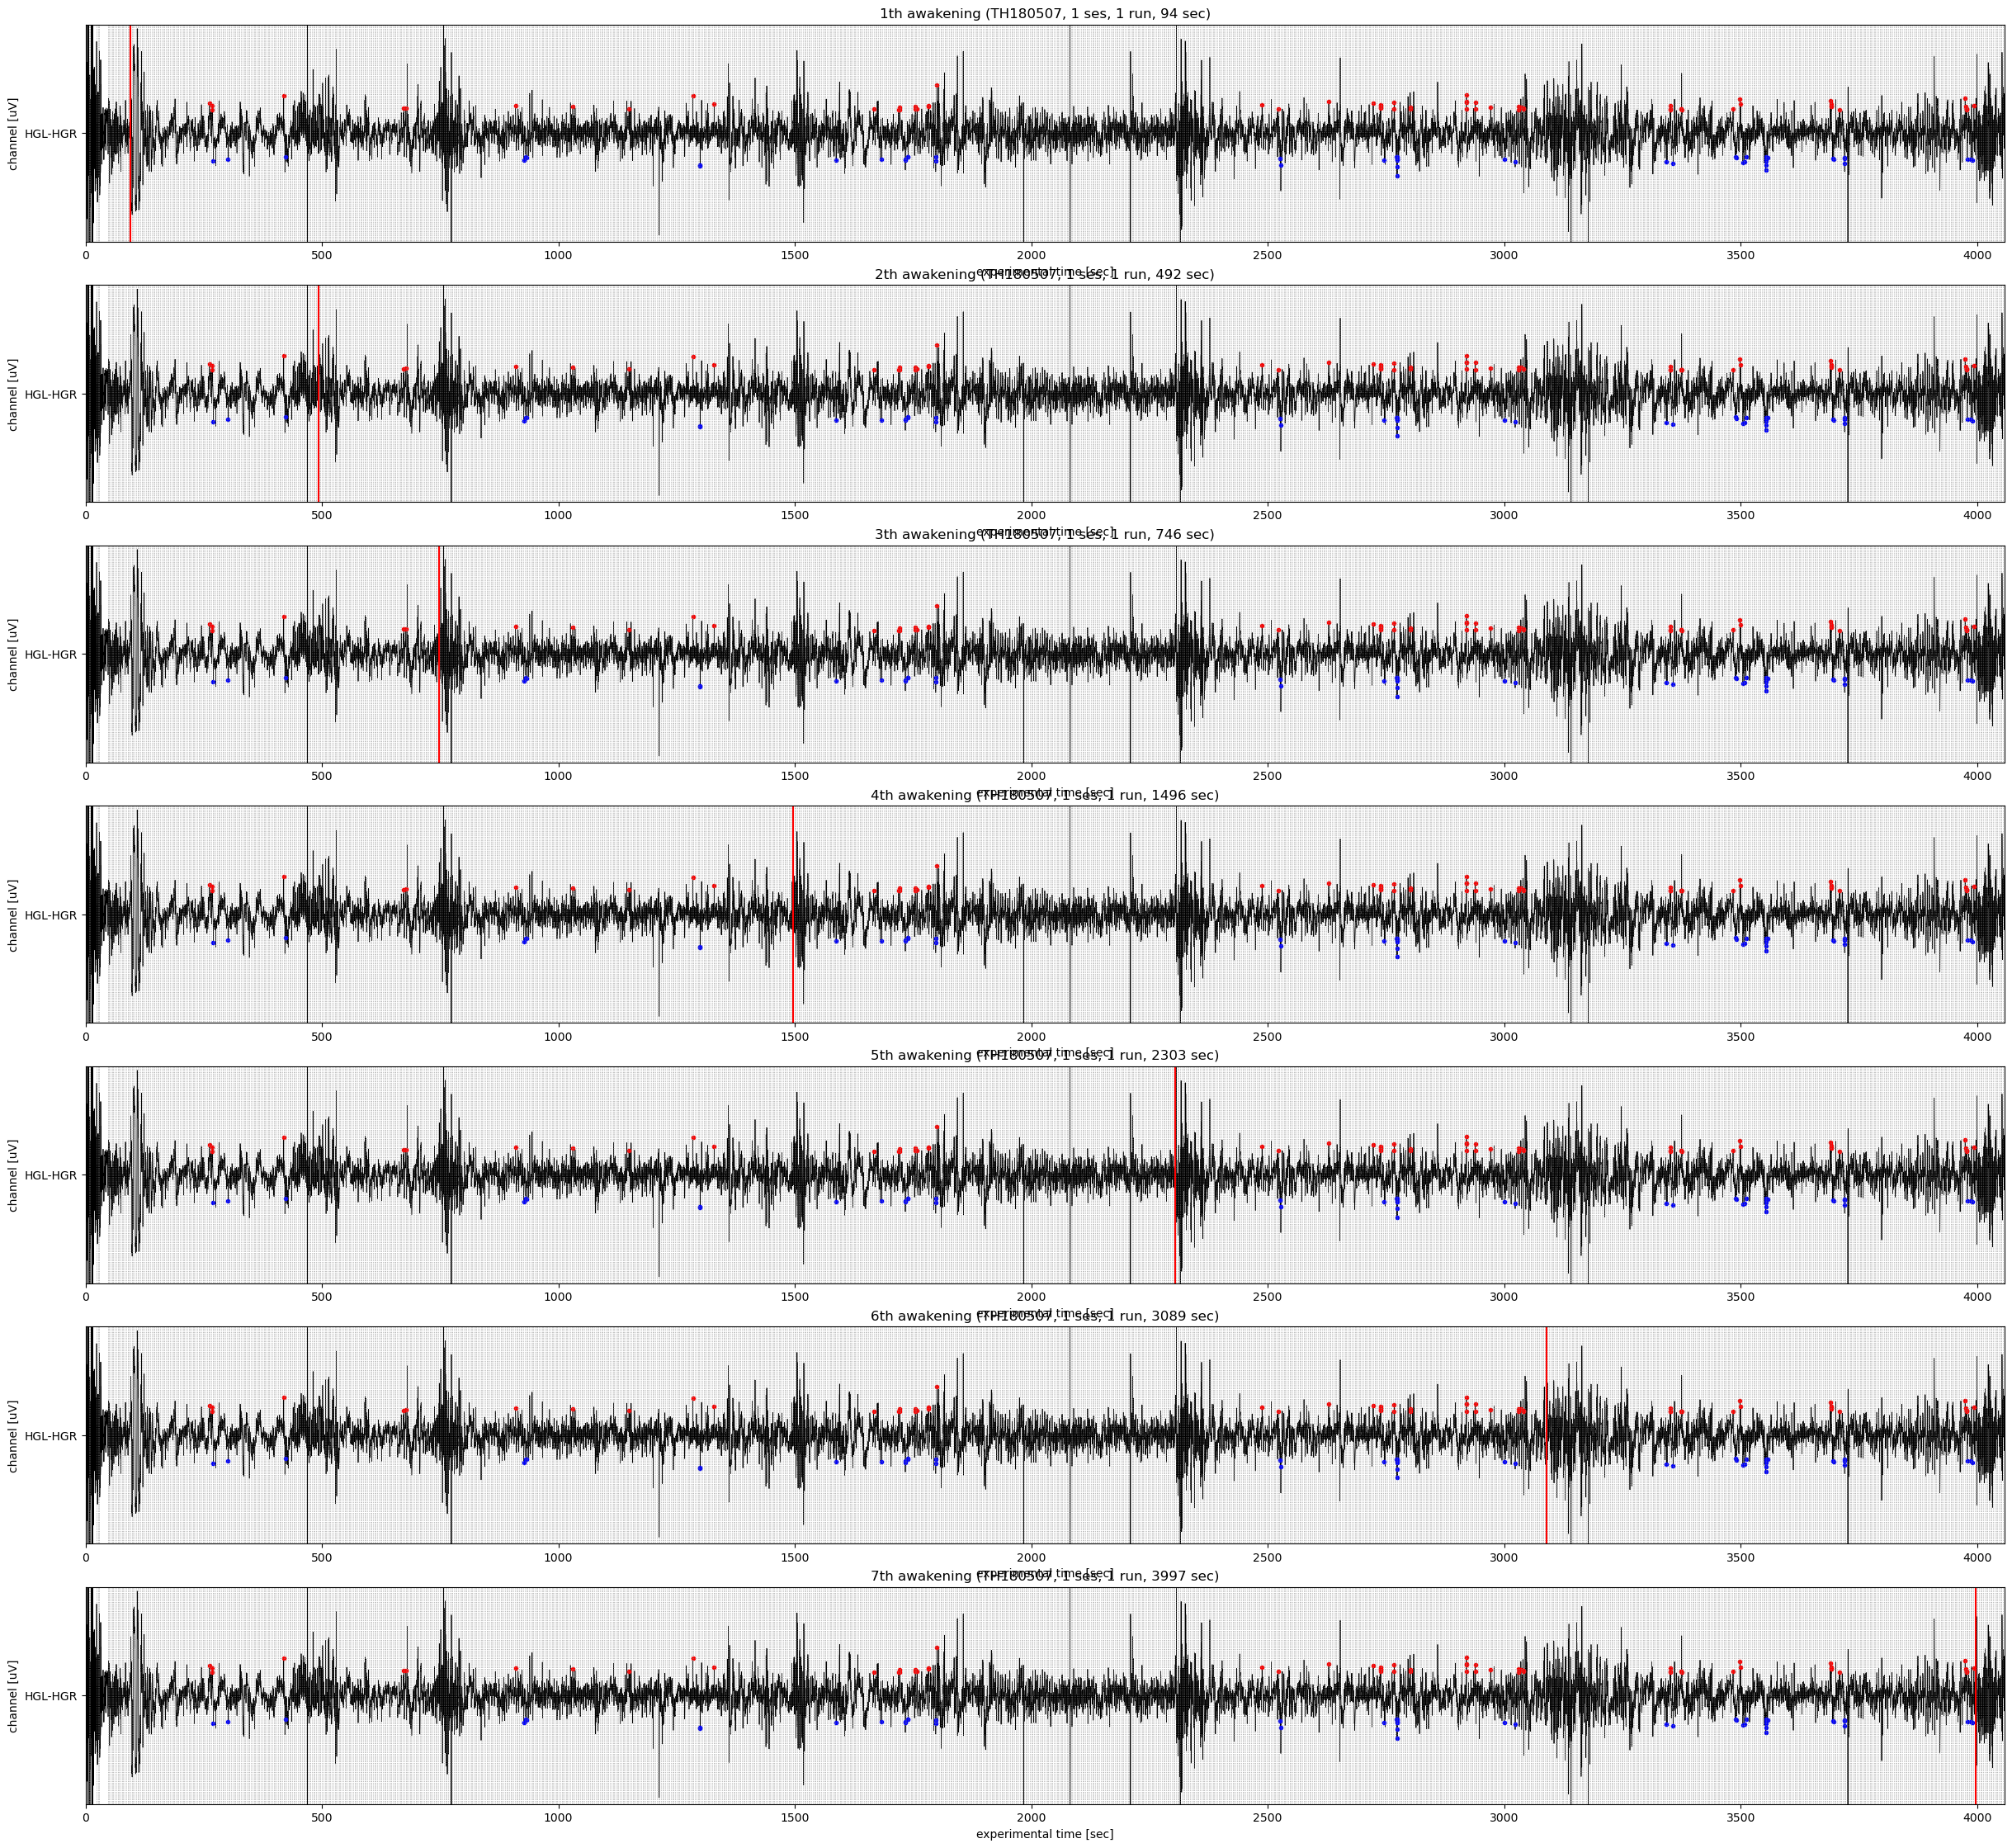

In [ ]:
#左右の推定
#右：１、　左：−１、　両方：２、　なし：０ をvolumeごとに出力

# Get event times
sleep_stamp_times = vhdr.get_event_onset_time('Comment/Sleeping')
awake_stamp_times = vhdr.get_event_onset_time('Comment/Awaking')
right_stamp_times = vhdr.get_event_onset_time('Comment/right')
left_stamp_times = vhdr.get_event_onset_time('Comment/left')
print("sleep button:", sleep_stamp_times)
print("awake button:", awake_stamp_times)
print("right button:", right_stamp_times)
print("left button:", left_stamp_times)
num_awakenings = len(awake_stamp_times)

step_size = 50 
geta = 500
pre_time = 300
post_time = 40
    
fig, axes = plt.subplots(len(awake_stamp_times), 1, figsize = (30, 4 * len(awake_stamp_times)))

if not (isinstance(axes, list) or isinstance(axes, np.ndarray)):
    axes = [axes]

intergrated_volume_stage = np.zeros(volume_num)

for n, awtime in enumerate(awakening_stamp_times):
    ax = axes[n]

    # 読み出し期間
    # pre = awtime - pre_time
    pre = 0
    #post = awtime + post_time
    post = 7000
    print(pre, post)

    # EEGデータのロード
    selected_channels = ["HGL", "HGR","SM1", "ECG"]
    signals, timepoints = vhdr.get_data(channel = selected_channels, period = [pre, post], return_times=True) #* 10**6    
    signal_dict = {}
    for schi, sch in enumerate(selected_channels):
        a_signal =  signals[schi]
        # scale調整をここに入れる
        a_signal = a_signal * 10**6
        # ダウンサンプリング
        a_signal = a_signal[::step_size]
        signal_dict[sch] = a_signal
    signal_dict["HGL-HGR"] = signal_dict["HGL"] - signal_dict["HGR"]
    # ダウンサンプリング
    timepoints = timepoints[::step_size]
    
    draw_channels = ["HGL-HGR"]
    right_time = []
    left_time = []
    result = []

    for dchi, dch in enumerate(draw_channels):
        signal = signal_dict[dch] + geta * dchi
        ax.plot(timepoints, signal, color='black', linewidth=0.3)

    sm1_values = signal_dict['SM1']
    ecg_values = signal_dict['ECG']

    for dchi, dch in enumerate(draw_channels):
        ax.plot(timepoints, signal_dict[dch] + geta * dchi, color='black', linewidth=0.5)
        
        #TH180507 のsession1 run3の時はノイズが大きいのでこちらの処理
        if (sbjid == "TH180507" and session == 1and run == 3):
            for i, value in enumerate(signal_dict[dch]):
                sm1_last3s = sm1_values[max(0, i-100):i]
                ecg_last3s = ecg_values[max(0, i-100):i]
                
                if (np.any(sm1_last3s >= 500) or np.any(sm1_last3s <= -500) or np.any(ecg_last3s >=2000) or np.any(ecg_last3s <= -2000)):
                    continue
                if not( signal_dict["SM1"][i] > 140 or signal_dict["SM1"][i]  < -140):
                    if value > 140:
                        ax.plot(timepoints[i], signal_dict[dch][i] + geta * dchi, 'ro', markersize=3)
                        left_time.append(timepoints[i])
                    elif value < -140:
                        ax.plot(timepoints[i], signal_dict[dch][i] + geta * dchi, 'bo', markersize=3)
                        right_time.append(timepoints[i])

        else:
            for i, value in enumerate(signal_dict[dch]):
                sm1_last3s = sm1_values[max(0, i-300):i]
                ecg_last3s = ecg_values[max(0, i-300):i]
            
             #過去3秒間にSM1の値が290以上、もしくは-290以下になっていれば、valueの評価を行わない 
            #過去3秒間にECGの値が1500以上、もしくは-1500以下になっていれば、valueの評価を行わない 
                if (np.any(sm1_last3s >= 290) or np.any(sm1_last3s <= -290) or np.any(ecg_last3s >=1500) or np.any(ecg_last3s <= -1500)):
                    continue
                
            # i 秒にSM1の値が140以上か-140以下であれば、valueの評価を行わない    
                if not( signal_dict["SM1"][i] > 140 or signal_dict["SM1"][i]  < -140):
                
                # HGL-HGRの値が140より大きい時は右、-140未満の時は左
                    if value > 140:
                        ax.plot(timepoints[i], signal_dict[dch][i] + geta * dchi, 'ro', markersize=3)
                        left_time.append(timepoints[i])
                    elif value < -140:
                        ax.plot(timepoints[i], signal_dict[dch][i] + geta * dchi, 'bo', markersize=3)
                        right_time.append(timepoints[i])

       
                
    ax.set_ylabel("channel [uV]")
    ax.set_yticks([geta * i for i in range(len(draw_channels))])
    ax.set_yticklabels(draw_channels)
    ax.set_ylim([-1.3*geta, geta*(len(draw_channels) + 0.3)])
    ax.set_xlabel("experimental time [sec]")
    
    count = 0
    # volume単位の情報描画
    pre_trigger_time  = trigger_time_list[0]
    for vi in range(volume_num):
        trigger_time = trigger_time_list[vi]
        if trigger_time > timepoints[0] and trigger_time < timepoints[-1]:
            ax.axvline(trigger_time, c="gray", lw=0.5, ls="dotted")
        if intergrated_volume_stage[vi] == 4:
            ax.axvspan(trigger_time, trigger_time + tr, color="red", alpha=0.1)
        elif intergrated_volume_stage[vi] == 0:
            pass
        elif intergrated_volume_stage[vi] in [1,2,3]:
            ax.axvspan(trigger_time, trigger_time + tr, color="green", alpha=0.1)
            
        #volumeごとに判定結果をリストに格納
        if any(pre_trigger_time <= x <= trigger_time for x in left_time):
            if any(pre_trigger_time <= y <= trigger_time for y in right_time):
                result.append(2)
            else:
                result.append(-1)
        elif any(pre_trigger_time <= z<= trigger_time for z in right_time):
            result.append(1)
        else:
            result.append(0)
        pre_trigger_time = trigger_time
        count = count + 1

    ax.set_xlim([timepoints[0], timepoints[-1]])
    ax.axvline(awtime, c="red")
    ax.set_title("%dth awakening (%s, %d ses, %d run, %d sec)" % (n+1, sbjid, session, run, awtime))
    
filename = "%s_ses%s_run%s.csv" % (sbjid, session, run)
np.savetxt(filename, result, delimiter=',', fmt='%d')
print("Saved file:", filename)

print("len:", len(result))
    
#1250 
#2150
#2550
#2625

1600 2200
1600 2200
1600 2200
1600 2200
1600 2200
1600 2200
1600 2200


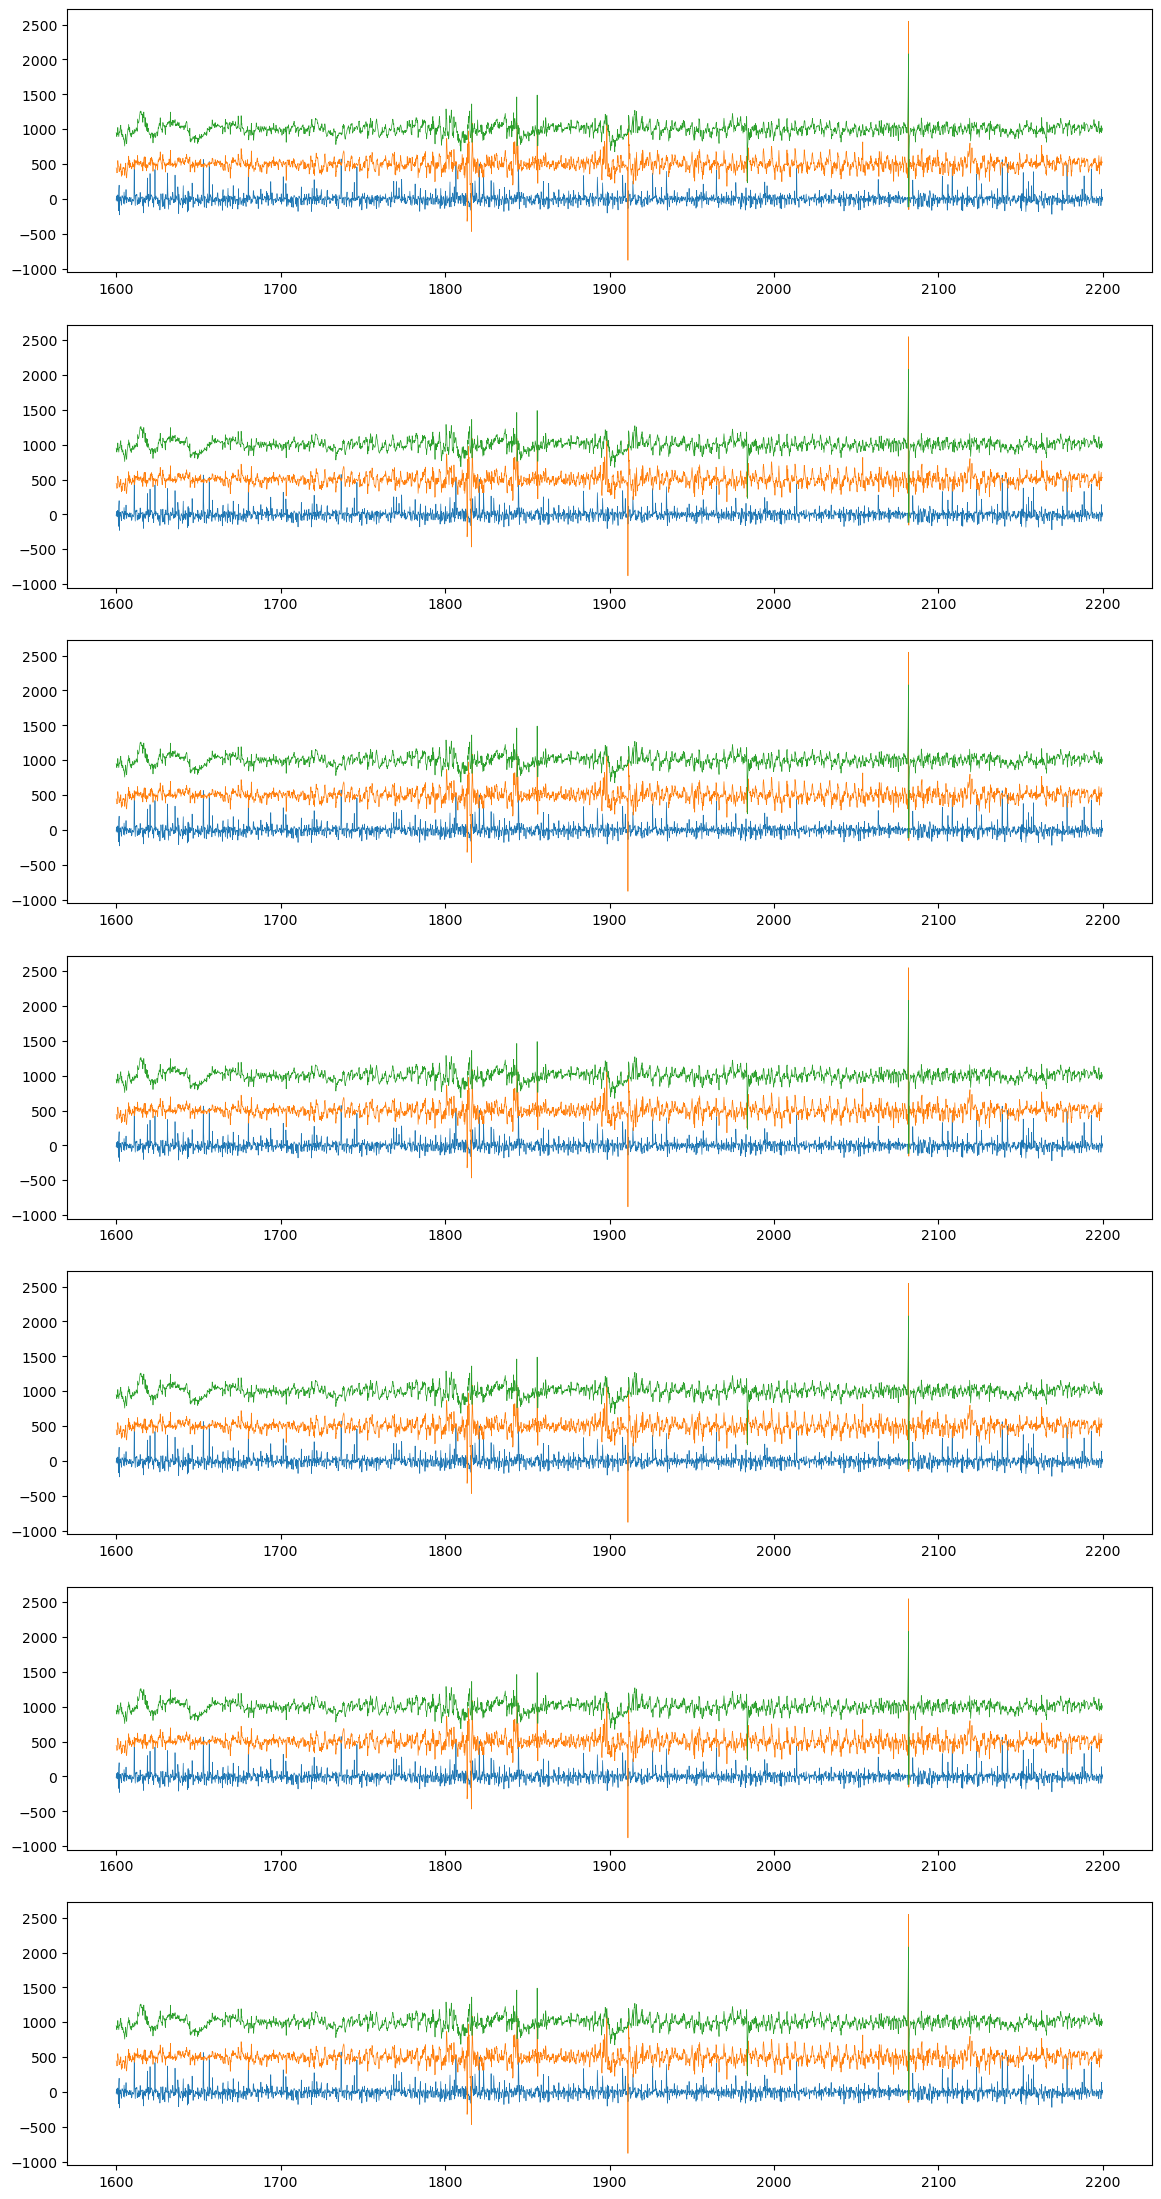

In [ ]:

#SM１の降順

# Visualize EEG wave

step_size = 50
geta = 500
pre_time = 300
post_time = 40

fig, axes = plt.subplots(len(awake_stamp_times), 1, figsize = (14, 4 * len(awake_stamp_times)))

if not (isinstance(axes, list) or isinstance(axes, np.ndarray)):
    axes = [axes]

for n, awtime in enumerate(awake_stamp_times):
    ax = axes[n]

    # 読み出し期間
    pre =1600
    #post = awtime + post_time
    post = 2200
    print(pre, post)

    # EEGデータのロード
    selected_channels = ["ECG","SM1","HGL","HGR"]
    signals, timepoints = vhdr.get_data(channel = selected_channels, period = [pre, post], return_times=True) #* 10**6    
    signal_dict = {}
    for schi, sch in enumerate(selected_channels):
        a_signal =  signals[schi]
        # scale調整をここに入れる
        a_signal = a_signal * 10**6
        # ダウンサンプリング
        a_signal = a_signal[::step_size]
        signal_dict[sch] = a_signal
    signal_dict["HGL-HGR"] = signal_dict["HGL"] - signal_dict["HGR"]

    # ダウンサンプリング
    timepoints = timepoints[::step_size]

    # 描画
    draw_channels = ["ECG","SM1","HGL-HGR"]
    for dchi, dch in enumerate(draw_channels):
        ax.plot(timepoints, signal_dict[dch] + geta * dchi, linewidth = 0.5)

#以下を利用して、閾値を決める
# HGRの値を降順に並び替える
hgr_indices = np.argsort(signal_dict["SM1"])[::-1]
signal_dict["SM1"] = signal_dict["SM1"][hgr_indices]

timepoints = timepoints[hgr_indices]
signal_r = signal_dict["SM1"]

    

#for i in range(len(timepoints)):
  #  print("Time:",timepoints[i],"SM1:",signal_r[i])


